In [1]:
import os
import zipfile

# Define the path to your uploaded ZIP file in Colab
zip_file_path = '/content/archive.zip'  # Replace with the actual path and filename

# Define the directory where you want to extract the contents
extracted_dir = '/content/extracted_files'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extracted_dir)

print(f"Successfully extracted '{zip_file_path}' to '{extracted_dir}'")

Successfully extracted '/content/archive.zip' to '/content/extracted_files'


In [41]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [36]:
# Load the dataset
df = pd.read_csv('/content/extracted_files/Walmart.csv')

In [37]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [38]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [42]:
# Data Preprocessing
def preprocess_data(df):
    # Convert date to datetime
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

    # Extract temporal features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week

    # Handle missing values
    numerical_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    for col in numerical_cols:
        df[col].fillna(df[col].median(), inplace=True)

    # Feature engineering
    df['Store_Size_Category'] = pd.qcut(df['Store'], q=3, labels=['Small', 'Medium', 'Large'])
    df['IsHoliday'] = df['Holiday_Flag']  # Create IsHoliday column

    # One-hot encoding
    df = pd.get_dummies(df, columns=['Store_Size_Category', 'IsHoliday'], drop_first=True)

    # Feature selection
    features = ['Store', 'Temperature', 'Fuel_Price', 'CPI',
               'Unemployment', 'Year', 'WeekOfYear'] + \
               [col for col in df.columns if col.startswith('Store_Size_Category_') or col.startswith('IsHoliday_')]

    # Scaling
    scaler = MinMaxScaler()
    numerical_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'WeekOfYear']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    df['Is_Thanksgiving_Week'] = (df['WeekOfYear'] == 47).astype(int)
    df['Yearly_Growth'] = df.groupby('Store')['Weekly_Sales'].pct_change()

    return df[features], df['Weekly_Sales']

# Preprocess the data
X, y = preprocess_data(df)

<ipython-input-42-1beb3cd2f9f7>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [44]:
# Correct way to use early stopping with XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [45]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'random_state': 55
}


In [46]:
# Train with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-rmse:512168.72017	test-rmse:522383.52837
[1]	train-rmse:466922.27489	test-rmse:477768.10038
[2]	train-rmse:427534.69425	test-rmse:439881.03646
[3]	train-rmse:406277.79377	test-rmse:420636.52464
[4]	train-rmse:371920.06596	test-rmse:386872.50320
[5]	train-rmse:339385.11292	test-rmse:354457.51877
[6]	train-rmse:311666.71573	test-rmse:327704.28643
[7]	train-rmse:286012.96283	test-rmse:302533.06645
[8]	train-rmse:268562.99978	test-rmse:287404.24906
[9]	train-rmse:248278.91455	test-rmse:269354.05506
[10]	train-rmse:236999.68876	test-rmse:260059.55830
[11]	train-rmse:220491.88583	test-rmse:244863.72282
[12]	train-rmse:211035.75833	test-rmse:236077.39973
[13]	train-rmse:196547.06620	test-rmse:222257.12683
[14]	train-rmse:185390.43717	test-rmse:212302.33178
[15]	train-rmse:174279.59697	test-rmse:202651.59625
[16]	train-rmse:164032.94562	test-rmse:193755.25392
[17]	train-rmse:158363.22984	test-rmse:189070.57183
[18]	train-rmse:149429.21439	test-rmse:181174.55786
[19]	train-rmse:141344


Model Evaluation:
MAE: $50,938.86
RMSE: $101,748.26


<Figure size 1000x600 with 0 Axes>

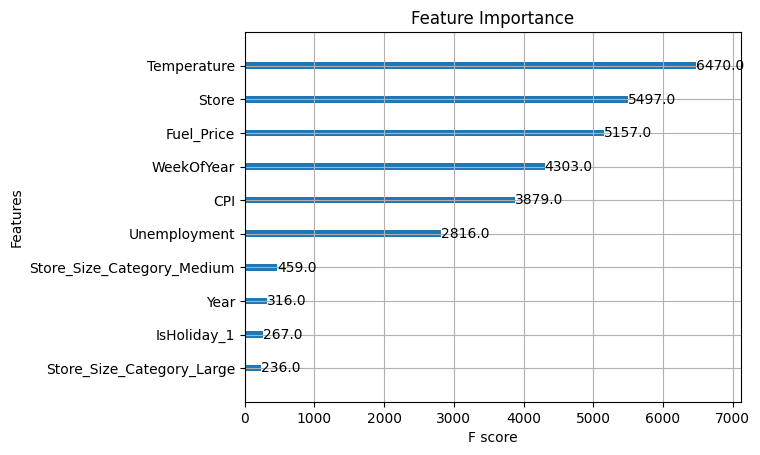

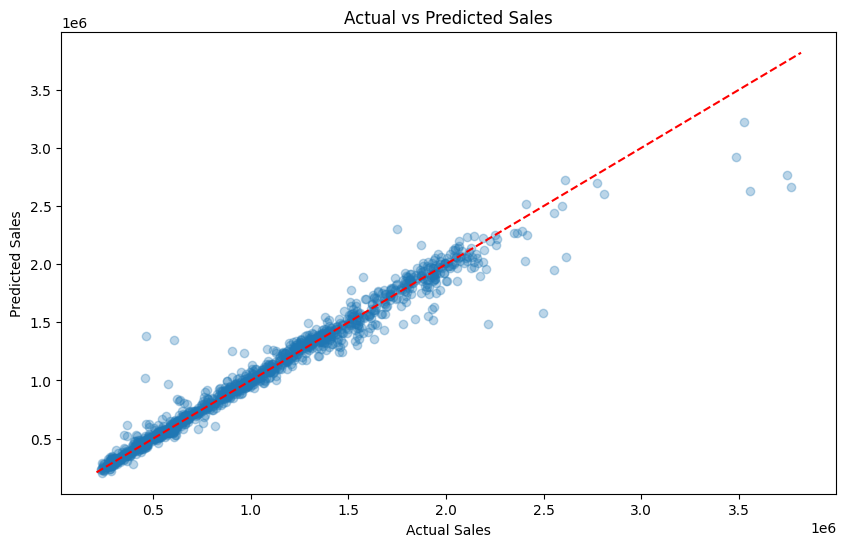

In [47]:
# Evaluation function (fixed)
def evaluate_model(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred = model.predict(dtest)

    print("\nModel Evaluation:")
    print(f"MAE: ${mean_absolute_error(y_test, y_pred):,.2f}")
    # Corrected RMSE calculation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: ${rmse:,.2f}")

    # Feature importance
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(model, max_num_features=15)
    plt.title("Feature Importance")
    plt.show()

    # Actual vs Predicted plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title('Actual vs Predicted Sales')
    plt.show()

# Run evaluation
evaluate_model(model, X_test, y_test)

In [48]:
# Convert test data to DMatrix format
dtest = xgb.DMatrix(X_test)

# Make predictions
y_pred = model.predict(dtest)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Display results
print("="*50)
print("MODEL ACCURACY REPORT")
print("="*50)
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Root Mean Squared Error: ${rmse:,.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.4f}")
print("="*50)

MODEL ACCURACY REPORT
Mean Absolute Error: $50,938.86
Root Mean Squared Error: $101,748.26
Mean Absolute Percentage Error: 5.21%
R-squared Score: 0.9684


In [49]:
# Save model in .h5 format
model.save_model('walmart_sales_model.h5')

# Download the model
from google.colab import files
files.download('walmart_sales_model.h5')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:29:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# Get the exact feature names from the trained model
feature_names = model.feature_names
print("Required features:", feature_names)

# Example input data - MUST MATCH THE TRAINING FEATURES EXACTLY
new_data = {
    'Store': [1],                   # Store number
    'Temperature': [42.31],         # Fahrenheit
    'Fuel_Price': [2.572],          # USD
    'CPI': [211.096358],            # Consumer Price Index
    'Unemployment': [8.106],        # Percentage
    'Year': [2012],                 # Year
    'WeekOfYear': [51],             # Week number (1-52)
    'Store_Size_Category_Medium': [0],  # Must match training categories
    'Store_Size_Category_Large': [0],   # Must match training categories
    'IsHoliday_1': [1]              # 0 or 1 (1=holiday week)
}

# Create DataFrame with EXACTLY the same columns as training
input_df = pd.DataFrame(columns=feature_names)
for col in feature_names:
    input_df[col] = new_data.get(col, 0)  # Fill missing with 0

# Scale numerical features (using same scaler from training)
numerical_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'WeekOfYear']
input_df[numerical_features] = scaler.transform(input_df[numerical_features])

# Convert to DMatrix
dinput = xgb.DMatrix(input_df)

Required features: ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'WeekOfYear', 'Store_Size_Category_Medium', 'Store_Size_Category_Large', 'IsHoliday_1']


In [57]:
# Make prediction
prediction = model.predict(dinput)

# Display result
print(f"Predicted Weekly Sales: ${prediction[0]:,.2f}")

Predicted Weekly Sales: $1,502,209.25
